In [ ]:
#load json file and then parse reddit format
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*80)
print("REDDIT CYBERSECURITY DATA PREPROCESSING & EXPLORATION")
print("="*80)



# Load JSONL file
def load_jsonl(file_path):
    rows = []
    with open(file_path, 'r') as file:
        for line in file:
            rows.append(json.loads(line))
    return pd.DataFrame(rows)

posts = load_jsonl("r_cybersecurity_posts.jsonl")
print(f"Loaded {len(posts)} posts")
# Store original count for comparison
original_count = len(posts)



: 

In [5]:
# Combine title and selftext
posts["title"] = posts["title"].fillna("")
posts["selftext"] = posts["selftext"].fillna("")
posts["text"] = (posts["title"].str.strip() + "\n" + posts["selftext"].str.strip()).str.strip()

print(posts["text"].iloc[0])

Mentorship Monday - Post All Career, Education and Job questions here!
This is the weekly thread for career and education questions and advice. There are no stupid questions; so, what do *you* want to know about certs/degrees, job requirements, and any other general cybersecurity career questions? Ask away!

Interested in what other people are asking, or think your question has been asked before? Have a look through prior weeks of content - though we're working on making this more easily searchable for the future.


In [6]:
#remove duplicates, reddit post ID is string, multiple pulls mean duplicates
posts = posts.drop_duplicates(subset=["id"])
print(f"After removing duplicates, {len(posts)} posts remain")


After removing duplicates, 39638 posts remain


In [7]:
# Filter subreddits (if needed - adjust based on your actual data)
# Since I only downloaded r/cybersecurity,  might skip this or keep only that one
if "subreddit" in posts.columns:
    subreddits_to_keep = ["cybersecurity"]  # Only actually have
    posts = posts[posts["subreddit"].str.lower().isin(subreddits_to_keep)]
    print(f"After filtering subreddits, {len(posts)} posts remain")

After filtering subreddits, 39638 posts remain


In [8]:
#Text cleaning using regex - python library
import re
def clean_text(text):
    if pd.isna(text) or text == "":
        return ""
    
    # Remove URLs (but preserve the fact they existed if needed)
    text = re.sub(r'http\S+|www\S+|https\S+', ' URL ', text, flags=re.MULTILINE)
    
    # Remove Reddit markdown formatting
    text = re.sub(r'\[([^\]]+)\]\([^\)]+\)', r'\1', text)  # [text](url) → text
    text = re.sub(r'\*\*([^\*]+)\*\*', r'\1', text)  # **bold** → bold
    text = re.sub(r'\*([^\*]+)\*', r'\1', text)  # *italic* → italic
    text = re.sub(r'~~([^~]+)~~', r'\1', text)  # ~~strikethrough~~ → strikethrough
    text = re.sub(r'#{1,6}\s', '', text)  # # headers

    # Remove Reddit-specific mentions (optional)
    text = re.sub(r'r/\w+', ' SUBREDDIT ', text)
    text = re.sub(r'u/\w+', ' USER ', text)

    # Remove brackets and their contents []  () {}
    text = re.sub(r'\[([^\]]*)\]', '', text)  # Remove [content]
    text = re.sub(r'\(([^\)]*)\)', '', text)  # Remove (content)
    text = re.sub(r'\{([^\}]*)\}', '', text)  # Remove {content}
    
    # Remove excessive punctuation but KEEP important ones
    # Keep: hyphens, dots, underscores (for CVE-2024-1234, IP: 192.168.1.1, file_name)
    text = re.sub(r'[^\w\s\.\-_:/]', ' ', text)  # Keep alphanumeric, dots, hyphens, underscores
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove special characters but keep spaces and basic punctuation
    text = re.sub(r'[^a-zA-Z\s\.\,\!\?\;\:]', ' ', text)

    # Convert to lowercase
    text = text.lower()
    
    # Optional: lowercase ONLY if you don't need to preserve acronyms
    # For cybersecurity, consider keeping original case
    # text = text.lower()
    
    return text
posts["cleaned_text"] = posts["text"].apply(clean_text)
# Add text length before and after cleaning
posts["original_text_len"] = posts["text"].str.len()
posts["cleaned_text_len"] = posts["cleaned_text"].str.len()

print(f"Text cleaning complete")
print(f"  Average original length: {posts['original_text_len'].mean():.0f} chars")
print(f"  Average cleaned length: {posts['cleaned_text_len'].mean():.0f} chars")



Text cleaning complete
  Average original length: 270 chars
  Average cleaned length: 233 chars


In [ ]:
#remove duplicates and low quality posts
#  Remove exact duplicates based on post ID
before_dedup = len(posts)
posts = posts.drop_duplicates(subset=["id"])
print(f" Removed {before_dedup - len(posts)} duplicate posts")

# Remove deleted/removed content
before_deleted = len(posts)
posts = posts[~posts["selftext"].isin(["[deleted]", "[removed]"])]
# posts = posts[~posts["author"].isin(["[deleted]", "[removed]"])] #check
print(f"Removed {before_deleted - len(posts)} deleted/removed posts")

# Remove very short posts (less than 10 characters after cleaning)
before_short = len(posts)
posts = posts[posts["cleaned_text_len"] > 10]
print(f" Removed {before_short - len(posts)} very short posts (<10 chars)")


# Remove posts with no meaningful text (all cleaning removed content)
before_empty = len(posts)
posts = posts[posts["cleaned_text"].str.strip().str.len() > 0]
print(f"Removed {before_empty - len(posts)} empty posts")

print(f"\nTotal posts remaining: {len(posts)} ({len(posts)/original_count*100:.1f}% of original)")


 Removed 0 duplicate posts
Removed 20901 deleted/removed posts
 Removed 30 very short posts (<10 chars)
Removed 3 empty posts

Total posts remaining: 18704 (47.2% of original)


In [10]:
# Convert UTC timestamp to datetime
posts["created_date"] = pd.to_datetime(posts["created_utc"], unit='s')
posts["year"] = posts["created_date"].dt.year
posts["month"] = posts["created_date"].dt.month
posts["day_of_week"] = posts["created_date"].dt.day_name()
posts["hour"] = posts["created_date"].dt.hour
posts["year_month"] = posts["created_date"].dt.to_period('M')

print(f"✓ Date range: {posts['created_date'].min()} to {posts['created_date'].max()}")
print(f"  - Total days covered: {(posts['created_date'].max() - posts['created_date'].min()).days}")


✓ Date range: 2024-01-01 00:00:13 to 2024-12-30 23:46:46
  - Total days covered: 364


In [11]:
#STATISTICS
print("\n" + "="*80)
print("DATASET PROFILE")
print("="*80)

# Basic statistics
print(f"\nBASIC STATISTICS:")
print(f"  Total posts: {len(posts):,}")
print(f"  Unique authors: {posts['author'].nunique():,}")
print(f"  Date range: {posts['created_date'].min().date()} to {posts['created_date'].max().date()}")
print(f"  Subreddits covered: {posts['subreddit'].nunique()}")

# Post type distribution
print(f"\nPOST TYPES:")
# print(f"  Self posts (text): {posts['is_self_post'].sum():,} ({posts['is_self_post'].sum()/len(posts)*100:.1f}%)")
# print(f"  Link posts: {posts['has_link'].sum():,} ({posts['has_link'].sum()/len(posts)*100:.1f}%)")

# Text length statistics
print(f"\n TEXT LENGTH STATISTICS:")
print(f"  Mean: {posts['cleaned_text_len'].mean():.0f} characters")
print(f"  Median: {posts['cleaned_text_len'].median():.0f} characters")
print(f"  Min: {posts['cleaned_text_len'].min():.0f} characters")
print(f"  Max: {posts['cleaned_text_len'].max():.0f} characters")
print(f"  Std: {posts['cleaned_text_len'].std():.0f} characters")

# Engagement statistics
print(f"\n ENGAGEMENT METRICS:")
print(f"  Mean score: {posts['score'].mean():.1f}")
print(f"  Median score: {posts['score'].median():.1f}")
print(f"  Mean comments: {posts['num_comments'].mean():.1f}")
print(f"  Median comments: {posts['num_comments'].median():.1f}")
print(f"  Total comments: {posts['num_comments'].sum():,}")

# Top authors
print(f"\n TOP 10 AUTHORS BY POST COUNT:")
top_authors = posts.groupby('author').size().sort_values(ascending=False).head(10)
for i, (author, count) in enumerate(top_authors.items(), 1):
    avg_score = posts[posts['author'] == author]['score'].mean()
    print(f"  {i:2d}. {author:30s}: {count:4d} posts (avg score: {avg_score:.1f})")

# Most engaged posts
print(f"\n TOP 5 MOST ENGAGED POSTS (by score):")
top_engaged = posts.nlargest(5, 'score')[['title', 'score', 'num_comments', 'author']]
for i, row in enumerate(top_engaged.itertuples(), 1):
    title_preview = row.title[:60] + "..." if len(row.title) > 60 else row.title
    print(f"  {i}. {title_preview}")
    print(f"     Score: {row.score}, Comments: {row.num_comments}, Author: {row.author}")

# Temporal distribution
print(f"\n TEMPORAL DISTRIBUTION:")
posts_by_month = posts.groupby('year_month').size()
print(f"  Average posts per month: {posts_by_month.mean():.1f}")
print(f"  Busiest month: {posts_by_month.idxmax()} ({posts_by_month.max()} posts)")
print(f"  Slowest month: {posts_by_month.idxmin()} ({posts_by_month.min()} posts)")

# Day of week distribution
print(f"\n POSTS BY DAY OF WEEK:")
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
posts_by_day = posts.groupby('day_of_week').size().reindex(day_order)
for day, count in posts_by_day.items():
    print(f"  {day:10s}: {count:5d} posts ({count/len(posts)*100:.1f}%)")

# Posting time distribution
print(f"\n PEAK POSTING HOURS (Top 5):")
posts_by_hour = posts.groupby('hour').size().sort_values(ascending=False)
for hour, count in posts_by_hour.head(5).items():
    print(f"  Hour {hour:02d}:00: {count:4d} posts ({count/len(posts)*100:.1f}%)")



DATASET PROFILE

BASIC STATISTICS:
  Total posts: 18,704
  Unique authors: 11,862
  Date range: 2024-01-01 to 2024-12-30
  Subreddits covered: 1

POST TYPES:

 TEXT LENGTH STATISTICS:
  Mean: 445 characters
  Median: 277 characters
  Min: 11 characters
  Max: 31932 characters
  Std: 686 characters

 ENGAGEMENT METRICS:
  Mean score: 23.5
  Median score: 1.0
  Mean comments: 12.6
  Median comments: 2.0
  Total comments: 236,427

 TOP 10 AUTHORS BY POST COUNT:
   1. arqf_                         :  230 posts (avg score: 51.4)
   2. wewewawa                      :  126 posts (avg score: 29.8)
   3. CYRISMA_Buddy                 :  123 posts (avg score: 43.8)
   4. DerBootsMann                  :   87 posts (avg score: 93.8)
   5. anynamewillbegood             :   71 posts (avg score: 77.8)
   6. anynamewillbefine             :   69 posts (avg score: 63.2)
   7. JCTopping                     :   66 posts (avg score: 21.7)
   8. z3nch4n                       :   66 posts (avg score: 34.0)


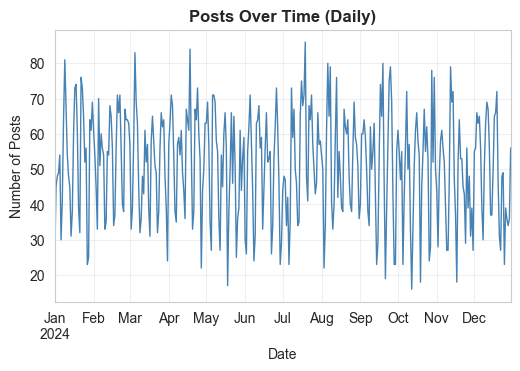

In [12]:
#visualizations 
# Create a figure with multiple subplots
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 12))

# 1. Posts over time
ax1 = plt.subplot(3, 3, 1)
posts_over_time = posts.set_index('created_date').resample('D').size()
posts_over_time.plot(ax=ax1, color='steelblue', linewidth=1)
ax1.set_title('Posts Over Time (Daily)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Posts')
ax1.grid(True, alpha=0.3)



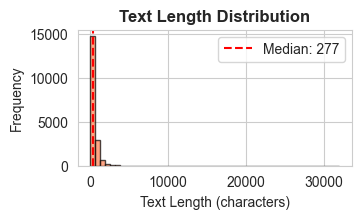

In [13]:
# 2. Text length distribution
ax2 = plt.subplot(3, 3, 2)
posts['cleaned_text_len'].hist(bins=50, ax=ax2, color='coral', edgecolor='black', alpha=0.7)
ax2.set_title('Text Length Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Text Length (characters)')
ax2.set_ylabel('Frequency')
ax2.axvline(posts['cleaned_text_len'].median(), color='red', linestyle='--', label=f'Median: {posts["cleaned_text_len"].median():.0f}')
ax2.legend()



Text(0, 0.5, 'Frequency (log)')

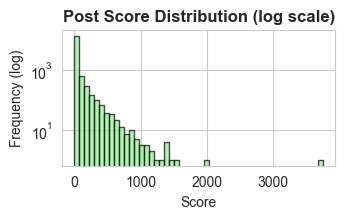

In [14]:
# 3. Score distribution (log scale)
ax3 = plt.subplot(3, 3, 3)
posts[posts['score'] > 0]['score'].hist(bins=50, ax=ax3, color='lightgreen', edgecolor='black', alpha=0.7)
ax3.set_yscale('log')
ax3.set_title('Post Score Distribution (log scale)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Score')
ax3.set_ylabel('Frequency (log)')



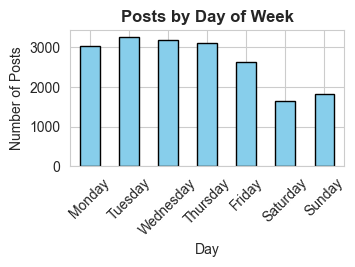

In [15]:
# 4. Posts by day of week
ax4 = plt.subplot(3, 3, 4)
posts_by_day.plot(kind='bar', ax=ax4, color='skyblue', edgecolor='black')
ax4.set_title('Posts by Day of Week', fontsize=12, fontweight='bold')
ax4.set_xlabel('Day')
ax4.set_ylabel('Number of Posts')
ax4.tick_params(axis='x', rotation=45)

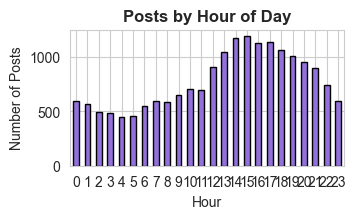

In [16]:
# 5. Posts by hour
ax5 = plt.subplot(3, 3, 5)
posts_by_hour.sort_index().plot(kind='bar', ax=ax5, color='mediumpurple', edgecolor='black')
ax5.set_title('Posts by Hour of Day', fontsize=12, fontweight='bold')
ax5.set_xlabel('Hour')
ax5.set_ylabel('Number of Posts')
ax5.tick_params(axis='x', rotation=0)

Text(0, 0.5, 'Frequency (log)')

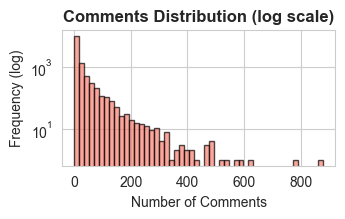

In [17]:
# 6. Comments distribution
ax6 = plt.subplot(3, 3, 6)
posts[posts['num_comments'] > 0]['num_comments'].hist(bins=50, ax=ax6, color='salmon', edgecolor='black', alpha=0.7)
ax6.set_yscale('log')
ax6.set_title('Comments Distribution (log scale)', fontsize=12, fontweight='bold')
ax6.set_xlabel('Number of Comments')
ax6.set_ylabel('Frequency (log)')

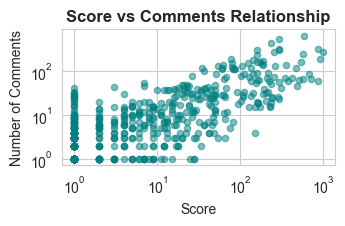

In [18]:

# 7. Score vs Comments scatter
ax7 = plt.subplot(3, 3, 7)
sample = posts.sample(min(1000, len(posts)))  # Sample for performance
ax7.scatter(sample['score'], sample['num_comments'], alpha=0.5, s=20, color='teal')
ax7.set_title('Score vs Comments Relationship', fontsize=12, fontweight='bold')
ax7.set_xlabel('Score')
ax7.set_ylabel('Number of Comments')
ax7.set_xscale('log')
ax7.set_yscale('log')


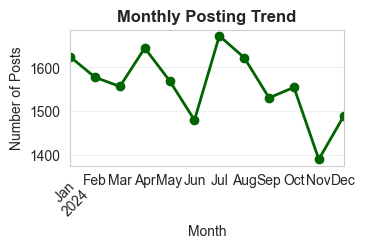

In [19]:
# 8. Monthly posting trend
ax8 = plt.subplot(3, 3, 8)
monthly_posts = posts.groupby('year_month').size()
monthly_posts.plot(kind='line', ax=ax8, marker='o', color='darkgreen', linewidth=2)
ax8.set_title('Monthly Posting Trend', fontsize=12, fontweight='bold')
ax8.set_xlabel('Month')
ax8.set_ylabel('Number of Posts')
ax8.tick_params(axis='x', rotation=45)
ax8.grid(True, alpha=0.3)


 Visualization saved: reddit_cybersecurity_analysis.png


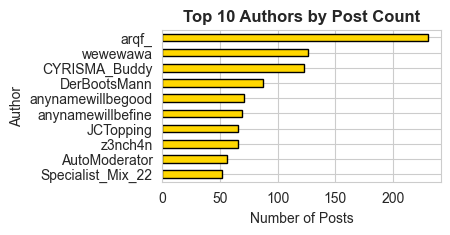

In [20]:


# 9. Top 10 authors
ax9 = plt.subplot(3, 3, 9)
top_authors.head(10).plot(kind='barh', ax=ax9, color='gold', edgecolor='black')
ax9.set_title('Top 10 Authors by Post Count', fontsize=12, fontweight='bold')
ax9.set_xlabel('Number of Posts')
ax9.set_ylabel('Author')
ax9.invert_yaxis()

plt.tight_layout()
plt.savefig('reddit_cybersecurity_analysis.png', dpi=300, bbox_inches='tight')
print(f" Visualization saved: reddit_cybersecurity_analysis.png")


In [ ]:
# Select only columns that actually exist
out_cols = [
    'id', 'subreddit', 'author', 'created_date', 'created_utc',
    'title', 'selftext', 'text', 'cleaned_text',
    'score', 'num_comments', 'is_self_post', 'has_link',
    'original_text_len', 'cleaned_text_len',
    'year', 'month', 'day_of_week', 'hour',
    'low_engagement',
    'permalink', 'url'
]

# Keep only columns that exist in the dataframe
posts_final = posts[[c for c in out_cols if c in posts.columns]]

# Save processed data
posts_final.to_csv("posts_processed2.csv", index=False)
print(f"\nSaved {len(posts_final)} processed posts to posts_processed.csv")

# Create a summary statistics file
summary_stats = {
    'Total Posts': len(posts),
    'Date Range Start': str(posts['created_date'].min()),
    'Date Range End': str(posts['created_date'].max()),
    'Unique Authors': posts['author'].nunique(),
    'Mean Score': posts['score'].mean(),
    'Mean Comments': posts['num_comments'].mean(),
    'Mean Text Length': posts['cleaned_text_len'].mean()
    # 'Low Engagement Posts': low_engagement_count,
    # 'Potential Spam Posts': spam_count,
    # 'Self Posts': posts['is_self_post'].sum(),
    # 'Link Posts': posts['has_link'].sum(),
}

summary_df = pd.DataFrame([summary_stats]).T
summary_df.columns = ['Value']
summary_df.to_csv('dataset_summary1.csv')
print(f" Saved summary statistics to: dataset_summary.csv")

print("\n" + "="*80)
print("PREPROCESSING & EXPLORATION COMPLETE!")
print("="*80)
print(f"\nOutput files created:")
print(f"  1. posts_processed_enhanced.csv - Main processed dataset")
print(f"  2. dataset_summary.csv - Summary statistics")
print(f"  3. reddit_cybersecurity_analysis.png - Visualization dashboard")



Saved 18704 processed posts to posts_processed.csv
 Saved summary statistics to: dataset_summary.csv

PREPROCESSING & EXPLORATION COMPLETE!

Output files created:
  1. posts_processed_enhanced.csv - Main processed dataset
  2. dataset_summary.csv - Summary statistics
  3. reddit_cybersecurity_analysis.png - Visualization dashboard
